In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage

def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)


In [2]:
! curl http://6.869.csail.mit.edu/sp21/pset3_data/bill.avi > bill.avi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  678k    1  9778    0     0   8082      0  0:01:25  0:00:01  0:01:24  8101
  5  678k    5 37352    0     0  26103      0  0:00:26  0:00:01  0:00:25 26138
100  678k  100  678k    0     0   292k      0  0:00:02  0:00:02 --:--:--  293k


## Problem 1.a

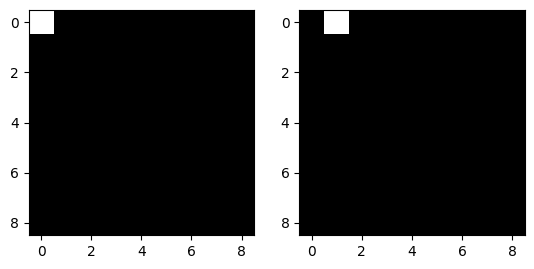

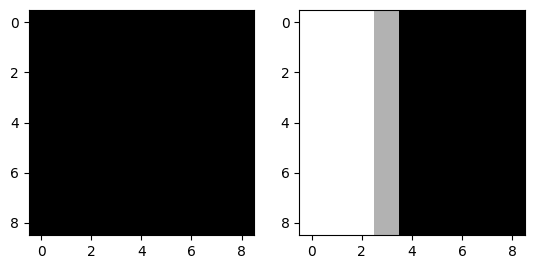

In [5]:
# 9x9 images
imSize = 9

# we would like to magnify the change between im1 and im2 by 4x
magnificationFactor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([imSize, imSize])
im2 = np.zeros([imSize, imSize])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))

plt.figure()
plt.subplot(121)
imshow(im1)
plt.subplot(122)
imshow(im2)

plt.figure()
plt.subplot(121)
imshow(angle(ff1))
plt.subplot(122)
imshow(angle(ff2))

### Magnify Change


In [6]:
def magnifyChange(im1, im2, magnificationFactor):

    # find phase shift in frequency domain
    im1Dft = fft2(im1)
    im2Dft = fft2(im2)
    phaseShift = angle(im2Dft) - angle(im1Dft)

    # magnify the phase change in frequency domain
    magnifiedDft = abs(im2Dft) * np.exp(1j * (angle(im1Dft) + magnificationFactor * phaseShift))

    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnifiedDft).real;

    return magnified

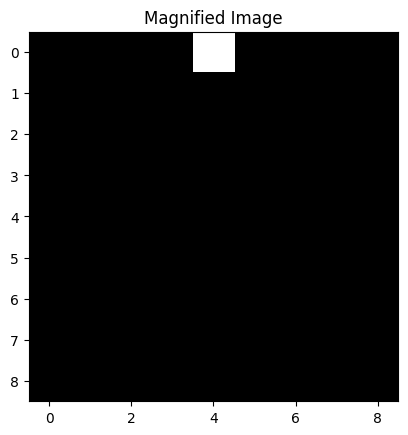

In [7]:
# Applying the magnifyChange function
magnified_image = magnifyChange(im1, im2, magnificationFactor)

# Plotting the result
plt.figure()
plt.imshow(magnified_image, cmap='gray')
plt.title('Magnified Image')
plt.show()

**HINT:** If you're not familiar with complex number in python, here's a quickstart.

In [12]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1.0000000000000002j)


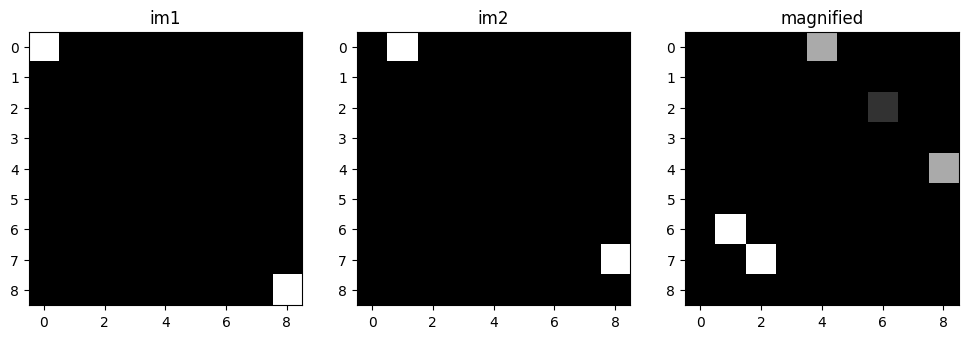

In [13]:
# magnify position change
magnified = magnifyChange(im1, im2, magnificationFactor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');
plt.savefig("problem_3a.png", bbox_inches="tight")

## Problem 1.b

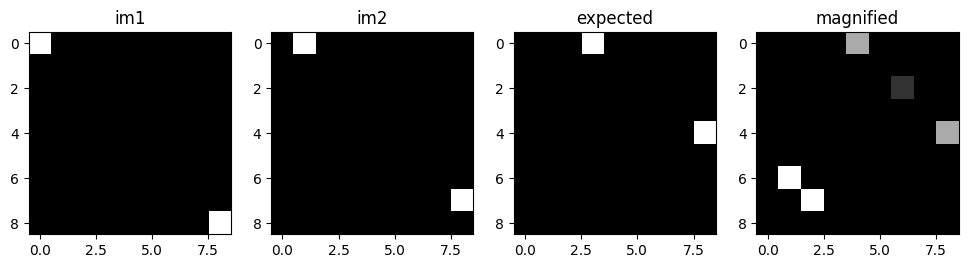

In [14]:
# 9x9 images
imSize = 9

# we would like to magnify the change between im1 and im2 by 4x
magnificationFactor = 4

# horizontal movement from (1, 1) to (1, 2)
# additional vertical movement from (9, 9) to (8, 9)
im1 = np.zeros([imSize, imSize])
im2 = np.zeros([imSize, imSize])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1


### TODO: ENTER YOUR CODE BELOW
### manually edit the expected matrix (currently set as zeros) by creating 1s to show the expected output
expected = np.zeros([imSize, imSize])
expected[0, 3] = 1  # Magnified horizontal movement (4x)
expected[4, 8] = 1  # Magnified vertical movement (4x)


# magnify position change
magnified = magnifyChange(im1, im2, magnificationFactor)


plt.figure(figsize=(12,36))
plt.subplot(141)
imshow(im1); plt.title('im1');

plt.subplot(142)
imshow(im2); plt.title('im2');

plt.subplot(143)
imshow(expected); plt.title('expected');

plt.subplot(144)
imshow(magnified); plt.title('magnified');
plt.savefig("problem_3b.png", bbox_inches="tight")

plt.show()

## Key Differences:

### Expected Output:
The expected matrix should show the locations of the impulse signals after they have been magnified by the specified factor. In this case, the impulse signal that moved horizontally should be at (0, 3) and the one that moved vertically should be at (4, 8).

### Magnified Output:
The actual magnified output may not perfectly match the expected matrix due to several factors, such as artifacts introduced by the magnification process and the Fourier transform's handling of phase shifts.

## Reason for Impulse Signal

**The unexpected impulse signal in the bottom left of the magnified output is due to the interaction of amplified phase shifts with the Fourier transform. When phase shifts are magnified, they affect the entire frequency spectrum, potentially introducing artifacts. Combining horizontal and vertical phase shifts can lead to complex interactions, resulting in unintended impulses. Additionally, edge effects and wrap-around artifacts, common with small images like 9x9, can cause unexpected signals in the output.**

## Problem 1.c

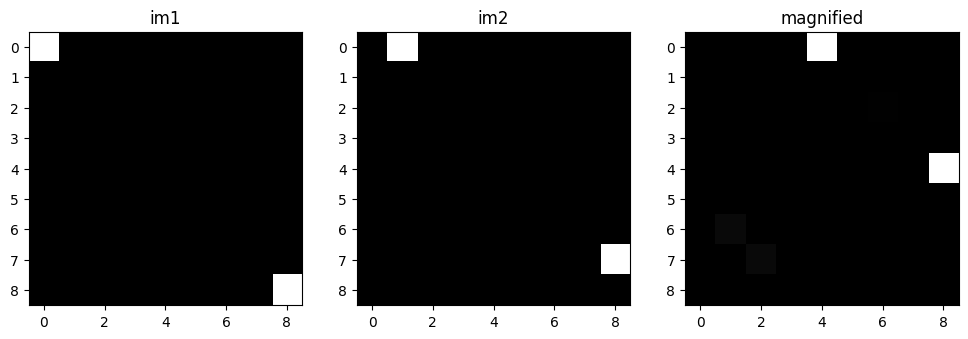

In [18]:
# 9x9 images
imSize = 9

# we would like to magnify the change between im1 and im2 by 4x
magnificationFactor = 4

# width of our Gaussian window
sigma = 2

# horizontal movement from (1, 1) to (1, 2)
# additional vertical movement from (9, 9) to (8, 9)
im1 = np.zeros([imSize, imSize])
im2 = np.zeros([imSize, imSize])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([imSize, imSize])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(imSize), np.arange(imSize))

for y in range(0, imSize, 2*sigma):
    for x in range(0, imSize, 2*sigma):
        gaussianMask = np.exp(-((X - x)**2 + (Y - y)**2) / (2 * sigma**2))
        windowMagnified = magnifyChange(im1 * gaussianMask, im2 * gaussianMask, magnificationFactor)
        magnified = magnified + windowMagnified

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1)
plt.title('im1')

plt.subplot(132)
imshow(im2)
plt.title('im2')

plt.subplot(133)
imshow(magnified)
plt.title('magnified')

plt.savefig("problem_3c.png", bbox_inches="tight")
plt.show()

## Problem 1.d

In [20]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()

    if ret is False:
        break

    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
numFrames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 240, 240, 3) # (nb_frames, height, width, channel)


### Motion magnification
Fill out code **here**

In [21]:
# 10x magnification of motion
magnificationFactor = 10

# width of Gaussian window
sigma = 13

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
xRange = list(range(0, width, 2*sigma))
yRange = list(range(0, height, 2*sigma))
numWindows = len(xRange) * len(yRange)
windowIndex = 1

for y in yRange:
    for x in xRange:
        for channelIndex in range(3): # RGB channels
            for frameIndex in range(numFrames):

                # create windowed frames
                gaussianMask = np.exp(-((X - x)**2 + (Y - y)**2) / (2 * sigma**2))
                windowedFrames = gaussianMask * frames[frameIndex,:,:,channelIndex]

                # initialize moving average of phase for current window/channel
                if frameIndex == 0:
                    windowAveragePhase = angle(fft2(windowedFrames))

                windowDft = fft2(windowedFrames)

                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                windowPhaseShift = angle(windowDft) - windowAveragePhase
                windowPhaseShift[windowPhaseShift > pi] = windowPhaseShift[windowPhaseShift > pi] - 2 * pi
                windowPhaseShift[windowPhaseShift < -pi] = windowPhaseShift[windowPhaseShift < -pi] + 2 * pi

                # magnify phase shift
                windowMagnifiedPhase = windowAveragePhase + magnificationFactor * windowPhaseShift

                # go back to image space
                windowMagnifiedDft = abs(windowDft) * np.exp(1j * windowMagnifiedPhase)
                windowMagnified = abs(ifft2(windowMagnifiedDft))

                # update moving average
                windowPhaseUnwrapped = windowAveragePhase + windowPhaseShift
                windowAveragePhase = alpha * windowAveragePhase + (1 - alpha) * windowPhaseUnwrapped

                # aggregate
                magnified[frameIndex,:,:,channelIndex] = magnified[frameIndex,:,:,channelIndex] + windowMagnified

        # print progress
        print('{}/{}'.format(windowIndex, numWindows), end='\r')
        windowIndex += 1

In [22]:
outputs = magnified / np.max(magnified)
for channelIndex in range(3):
    originalFrame = frames[0,:,:,channelIndex]
    magnifiedFrame = outputs[0,:,:,channelIndex]
    scale = np.std(originalFrame[:]) / np.std(magnifiedFrame[:])
    originalMean = np.mean(originalFrame[:])
    magnifiedMean = np.mean(magnifiedFrame[:])
    outputs[:,:,:,channelIndex] = magnifiedMean + scale * (outputs[:,:,:,channelIndex] - magnifiedMean)

outputs = np.clip(outputs, 0, 1)

In [23]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)

    # write frame to output video
    out.write(frame)

out.release()

In [ ]:
# # Only for colab downloading videos
# try:
#     from google.colab import files
#     files.download('bill_magnified.avi')
# except:
#     print("Only for google colab")

# Problem 2: Eulerian Motion Magnification 

Let's start by reading all the frames of the video.

In [42]:
import numpy as np
import cv2
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import os

# Check if the file exists
if not os.path.exists('baby.mp4'):
    print("Video file not found. Downloading...")
    !curl http://people.csail.mit.edu/mrub/evm/video/baby.mp4 > baby.mp4
else:
    print("Video file already exists.")

cap = cv2.VideoCapture('baby.mp4')
fps = int(cap.get(cv2.CAP_PROP_FPS))

# list of video frames
frames = []

frame_count = 0
while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()

    if ret is False:
        break
    frame = cv2.resize(frame, (424, 240))
    frame = frame[:, 80:80+240]
    frames.append(frame)
    frame_count += 1

    if frame_count % 100 == 0:
        print(f"Processed {frame_count} frames")

cap.release()

print(f"Total frames processed: {frame_count}")

if len(frames) == 0:
    print("No frames were read from the video.")
else:
    # scale frame to 0-1
    frames = np.array(frames) / 255.
    print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

    # get height, width
    numFrames = frames.shape[0]
    height = frames.shape[1]
    width = frames.shape[2]

    print(f"numFrames: {numFrames}, height: {height}, width: {width}")

# Helper function for displaying the pyramid

def intensityscale(image):
    """
    Scale the intensity of the image to the range [0, 1].
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val > min_val:
        return (image - min_val) / (max_val - min_val)
    return image  # Return original image if max == min to avoid division by zero

def display_pyramid(pyramid):
  N = len(pyramid)
  for lvl in range(len(pyramid)):
    plt.subplot(1, N, lvl+1)
    imshow(intensityscale(pyramid[lvl][0, ..., ::-1]))

Video file already exists.
Total frames processed: 0
No frames were read from the video.


# Problem 2a: Gaussian pyramid
We will first write a function to create a gaussian pyramid of the input frames. The function takes in an array of N frames (N, H, W, 3) and outputs a list of frames (num_levels, N, H, W, 3) such that each entry corresponds to the gaussian pyramid starting from the finest to the coarest level.



In [43]:
def create_gaussian_pyramid(vid, num_levels=4):
    # Initialize the pyramid list
    pyramid = [vid]
    
    # Create each level of the pyramid
    for level in range(1, num_levels):
        level_frames = []
        for frame in pyramid[level-1]:
            # Use cv2.pyrDown to downsample the frame
            downsampled = cv2.pyrDown(frame)
            level_frames.append(downsampled)
        pyramid.append(level_frames)
    
    return pyramid

In [44]:
gaussian_pyramid = create_gaussian_pyramid(frames)

TypeError: list indices must be integers or slices, not tuple

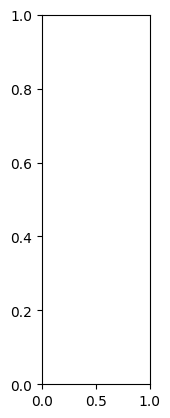

In [45]:
display_pyramid(gaussian_pyramid)
plt.savefig("gaussian_pyramid.png", bbox_inches="tight")

# Problem 2b: Laplacian pyramid
Now let's make the Laplacian pyramid using the gaussian pyramids you produced in 1a. Check that the returned frames take the form of (num_levels - 1, N, H, W, 3) [*sanity check: why?*]


In [ ]:
def create_laplacian_pyramid(gaussian_pyramid):
  ### TODO: ENTER YOUR CODE BELOW
  ### use the gaussian pyramid to create the laplacian pyramid for the video.
  ### You might find cv2.pyrUp function useful.

  return [] # returning empty list for now. Change this!

In [ ]:
laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)

In [ ]:
display_pyramid(laplacian_pyramid)
plt.savefig("laplacian_pyramid.png", bbox_inches="tight")

# Problem 2c: Butter bandpass filter temporally

In [ ]:
def butter_bandpass_filter(laplace_video, low_freq, high_freq, fs, filter_order=5):
    omega = 0.5 * fs
    low = low_freq / omega
    high = high_freq / omega

    # create a "bandpass" signal filter using the signal.butter function
    b, a = # TODO


    # filter the laplcian of the video using the signal.lfilter
    y = # TODO

    return y

amplification = 20
low = 0.4
high = 3.

bandpass_filtered = []
for i in range(len(laplacian_pyramid)):
    # Applying the butter_bandpass_filter to each of
    # the levels of the laplacian pyramid

    filter = butter_bandpass_filter(laplacian_pyramid[i], low, high, fps)
    filter *= amplification
    bandpass_filtered.append(filter)

# Problem 2d: Combining the amplified filtered signal to get the magnified video

In [ ]:
### TODO: ENTER YOUR CODE BELOW
### Combine all the bandpassed filtered signals to one matrix which is the same
### dimensions as the input video.
### Hint: start from the lowest resolution of the amplified filtered signal,
### upsample that using cv2.pyrUp and add it to the amplified filtered signal
### at the next higher resolution.

### The output video, 'euler_magnified_video', will be the
### input video frames + combined magnified signal.


In [ ]:
### Note:
### The output video will likely flicker and show severe magnification artifacts
### for about 4 seconds before showing a noisy magnified video.
### The initial artifacts should be ignored.

# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('baby_euler_magnification.avi', fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(euler_magnified_video[i], 0, 1) * 255).astype(np.uint8)

    # write frame to output video
    out.write(frame)

out.release()